In [15]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [16]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [17]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    # Original
    return (w[:d], w[d])

In [18]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [19]:
# Problem 2.1
def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    # Initialize the weights using provided function    
    w, w0 = Initialw(X, y)

    n, m = X.shape
    #print(n, m, y.shape, w.shape, w0.shape)
    
    # Initialize our iteratior, max change, and objective function
    iter = 0
    F = (1/2) * np.sum(X @ w + w0 -  y) + lmda * np.sum(np.absolute(w))

    while True:
        # Update iterator for given loop, reset our max_change, and calculate our new y_prime
        iter += 1
        max_change = 0

        for k in range(m):
            # Solve for r_k
            r_k = y - np.delete(X, [k], axis=1) @ np.delete(w, [k])

            # Solve for a_k and c_k
            X_k = X[:, k]
            a_k = 2 * np.sum(X_k**2)
            c_k = 2 * np.sum(np.multiply(r_k, X_k))

            # Calculate new w_k, cross-compare new weight to old weight to determine if max_change needs to be updated (for break condition), then save w_k at w[k]
            w_k = np.sign(c_k) * np.maximum(0, np.absolute(c_k) - lmda) / a_k
            if np.absolute(w_k - w[k]) > max_change:
                max_change = np.absolute(w_k - w[k])

            w[k] = w_k
            #print(w_k)
        
        # Calculate our new w0
        w0 =  np.mean(y) - np.mean(X, axis=0) @ w

        # Calculate our new objective value F
        F_new = (1/2) * np.sum(X @ w + w0 -  y) + lmda * np.sum(np.absolute(w))
        F = np.append(F, F_new)

        # After updating our weights, check against exit conditions: (1) number of steps will not exceed max_iter and (2) no element in w changes more than epsilon between successive iterations
        if iter > 100 or max_change <= epsilon:
            break

    # If draw_curve set to true, draw a plot of objective value with respect to coordinate descent step
    if draw_curve == True:
        fig, ax = plt.subplots(figsize=(10, 8))
        plt.plot(F, ls = '-', marker = 'o', label = '')
        plt.grid()
        plt.xlabel('Iteration')
        plt.ylabel('$Objective Value - F$')
        plt.title('Objective value $F$ as a function of coordinate descent step using lasso regression')
        fig.show()
        plt.savefig('Problem_3_a.png')

    return (w,w0)

In [20]:
# Problem 2.1: data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.9858945   0.9762621
   0.66088793]
 [-1.00421694 -0.98028568  1.04231343 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ...  1.13839265 -0.17706563
  -1.1040073 ]
 ...
 [ 0.22627269 -1.41473902 -1.38744153 ...  0.40629811  1.81803336
   0.57718998]
 [-0.87827944 -1.1588945  -0.20821426 ...  2.5616317   0.71706683
  -1.6834583 ]
 [ 1.18136184  0.97753967 -1.08284432 ... -0.26515022  1.70874717
   1.25566562]]
[ -2.94661658  -9.2469922   -6.61852337  -8.71813976  -2.77082316
 -21.16384608   2.47720978  -8.18425969  17.12490003  13.69805685
  27.11926075 -35.71631086 -11.85971212  18.6242186  -10.34229026
 -26.02528015 -38.1950294   19.8767635    0.46858206  -3.92985654
   8.35960867  22.22456719 -63.25244103  -7.14048583   8.24525032
  23.62138731 -28.79749873  -3.8576642   18.13970725  43.72678802
 -24.73981649  -8.27834954  40.86565523  32.20353774  -7.46417913
  -1.43551809 -33.9853813   15.26040273   9.931

[ 9.87701348 -9.72978372 -9.78533191  9.85809008 10.08126976  0.
 -0.          0.04990917 -0.         -0.         -0.         -0.02029786
  0.22101146 -0.          0.10649288 -0.          0.12528557  0.
 -0.         -0.          0.          0.01886022  0.01337888  0.01044934
  0.         -0.02632922 -0.          0.         -0.          0.
 -0.         -0.          0.          0.          0.08118375  0.
 -0.06709603 -0.         -0.         -0.          0.          0.
  0.          0.          0.          0.         -0.          0.
  0.04079482 -0.          0.         -0.          0.25100621 -0.
 -0.01947527 -0.          0.          0.         -0.          0.
 -0.         -0.03668451  0.         -0.13301942  0.          0.
 -0.          0.          0.          0.         -0.         -0.05597532
 -0.          0.          0.        ]


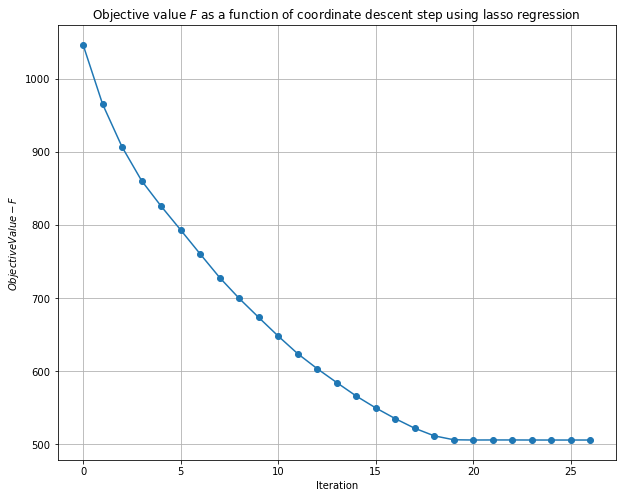

In [21]:
# Problem 2.1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)

In [22]:
# Problem 2.2
def pred_fn(X, theta, theta_0):
    pred = X @ theta + theta_0
    return pred

def root_mean_square_error(pred, y):
    rmse = np.sqrt(np.sum((pred - y)**2) / np.size(y))
    return rmse

def Evaluate(X, y, w, w0, w_true, w0_true):
    # First calculate the precision and recall - find the indices of each non-zero term in both w and w_true. Find the intersection of these two arrays of non-zero indices. Compute the precision and recall given equations (6) and (7).
    w_nonzero = np.nonzero(w)
    w_true_nonzero = np.nonzero(w_true)

    precision_w = np.size(np.intersect1d(w_nonzero, w_true_nonzero)) / np.size(w_nonzero)
    recall_w = np.size(np.intersect1d(w_nonzero, w_true_nonzero)) / np.size(w_true_nonzero)

    # Calculate RMSE using equation (5) from homework 2
    rmse = root_mean_square_error(pred_fn(X, w, w0), y)

    # Calculate sparsity
    sparsity_w = np.size(w_nonzero)

    return (rmse, sparsity_w, precision_w, recall_w)

In [23]:
# Problem 2.2
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
Emetric = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
print(Emetric)

(0.6112410261518306, 22, 0.22727272727272727, 1.0)


In [24]:
# Problem 2.3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y, filename='temp.png', lmda_start = 0):
    lmda_max = np.amax((y - np.average(y)).T @ X)
    n, m = X.shape
    
    l_range = 50
    Lmda = np.linspace(1*lmda_start, lmda_max, num=l_range)
    W = np.empty((m, 50))
    W0 = np.empty((1, 50))
    #print(Lmda)

    # Calculate our weights for each lambda and save to our value for W
    for i in range(l_range):
        w_lasso, w0_lasso = lasso(X, y, lmda = Lmda[i], epsilon = 1.0e-2, draw_curve = False, max_iter = 100)
        W[:, i] = w_lasso
        W0[:, i] = w0_lasso

    # Generate a 2D plot of our lasso solution path
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(Lmda, W.T[:, 1:5], ls = '-', marker = '.', c = 'green', label = '1st 5 Features (non-zero terms)')
    plt.plot(Lmda, W.T[:, 5:], ls = '-', marker = '.', c='black', label = 'Other Features (zero terms)')
    
    # Remove the duplicate labels from our labels to create a succient legend
    handles, labels = plt.gca().get_legend_handles_labels()
    newLabels, newHandles = [], []
    for handle, label in zip(handles, labels):
        if label not in newLabels:
            newLabels.append(label)
            newHandles.append(handle)
    
    plt.legend(newHandles, newLabels)

    plt.grid()
    #plt.legend()
    plt.xlabel('Lambda')
    plt.ylabel('')
    plt.title('Lasso solution path')
    fig.show()
    plt.savefig(filename) # If saving a file

    return (W, W0, Lmda)

In [25]:
# Problem 2.3
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda, filename='temp.png'):

    l_lmda = np.size(Lmda)

    RMSE = np.empty((1, l_lmda))
    Sparsity = np.empty((1, l_lmda))
    Precision = np.empty((1, l_lmda))
    Recall = np.empty((1, l_lmda))

    for i in range(np.size(Lmda)):
        RMSE[:,i], Sparsity[:, i], Precision[:,i], Recall[:,i] = Evaluate(X, y, W[:, i], W0[:, i], w_true, w0_true)
    
    # Generate a 2D plot of precision + recall vs. lmbda
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(Lmda, Precision.T, ls = '-', marker = '.', c = 'blue', label = 'Precision')
    plt.plot(Lmda, Recall.T, ls = '-', marker = '.', c='red', label = 'Recall')
    plt.grid()
    plt.legend()
    plt.xlabel('Lambda')
    plt.ylabel('')
    plt.title('Precision and Recall vs. $\lambda$')
    fig.show()
    plt.savefig(filename) # If saving a file

    return (RMSE, Sparsity, Precision, Recall)

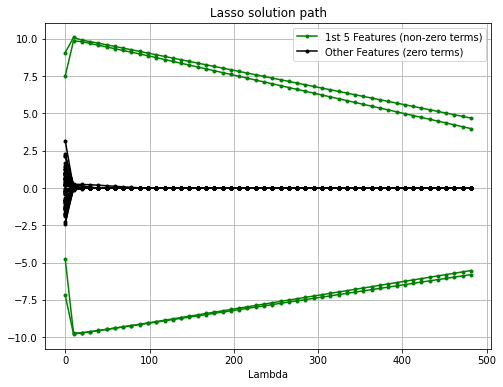

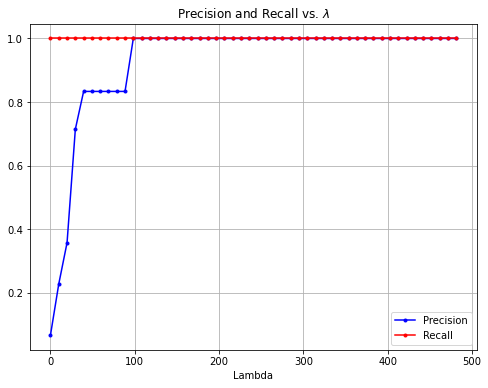

In [26]:
# Problem 2.3
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)

W, W0, Lmda = LassoPath(X, y, 'Problem_3_c_1.png')
RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda, 'Problem_3_c_2.png')

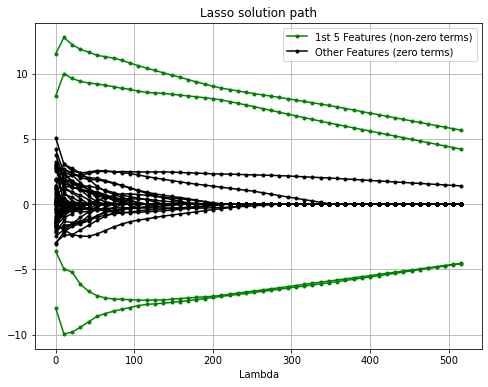

In [28]:
# Problem 2.3
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)

W, W0, Lmda = LassoPath(X, y, 'Problem_3_c_3.png')

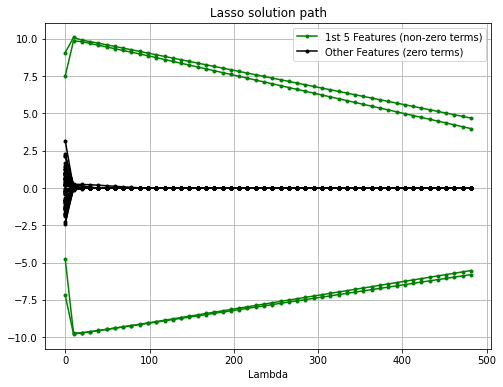

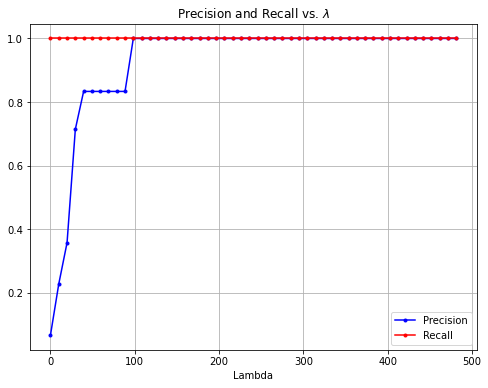

In [29]:
# Problem 2.4
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
n = 50
m = 75

X, y, w_true, w0_true = DataGenerator(n=n, d=m, k=5, sigma=1.0)
W, W0, Lmda = LassoPath(X, y)
RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

In [30]:
# Problem 2.5: predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

In [31]:
def lasso_sparse(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    #print(X.shape, y.shape)

    # Initialize the weights using provided function    
    w, w0 = Initialw(X, y)

    n, m = X.shape
    #print(n, m, y.shape, w.shape, w0.shape)
    
    X = sparse.csc_matrix(X)
    y = sparse.csc_matrix(y).transpose()
    w = sparse.csc_matrix(w).transpose()

    #print(X.shape, y.shape, w.shape, w0.shape)

    w0_temp = sparse.csc_matrix(np.ones(shape=(n,1)) * w0)
    # Initialize our iteratior, max change, and objective function
    iter = 0
    #print(X.shape, w.shape, w0_temp.shape, y.shape)
    F = (1/2) * np.sum(X.dot(w) + w0_temp - y) + lmda * abs(w).sum()

    #print('--Start of while loop')

    while True:
        # Update iterator for given loop and reset our max_change
        iter += 1
        print('Iteration: ', iter)
        max_change = 0

        # Comment out when running real-time
        start_time = datetime.now()
        #print('--Start of for loop')

        for k in range(m):
            start_loop_t = time.time()

            # Solve for r_k
            #X_less_k = X
            #X_less_k[:, k] = 0

            w_less_k = w
            w_less_k[k, 0] = 0

            #print(type(X_less_k), type(w_less_k), X_less_k.shape, w_less_k.shape)

            #X_less_k = np.delete(X.toarray(), [k], axis=1)
            #w_less_k = np.delete(w.toarray(), [k])
            r_k = y - X.dot(w_less_k)

            #print('time to solve for r_k: ', (time.time() - start_loop_t) * 1000)

            # Solve for a_k and c_k
            X_k = X[:, k]
            a_k = 2 * X_k.power(2).sum()
            c_k = 2 * X_k.multiply(r_k).sum()

            #print('time to solve for a_k/c_k: ', (time.time() - start_loop_t) * 1000)

            # Calculate new w_k, cross-compare new weight to old weight to determine if max_change needs to be updated (for break condition), then save w_k at w[k]
            w_k = np.sign(c_k) * np.maximum(0, np.absolute(c_k) - lmda) / a_k
            #w_delta[k] = np.absolute(w_k - w[k].toarray())
            
            if np.absolute(w_k - w[k].toarray()) > max_change:
                max_change = np.absolute(w_k - w[k].toarray())

            #print('time to solve for w_k + abs: ', (time.time() - start_loop_t) * 1000)

            w[k] = w_k
            #print(w_k)
        
        # Calculate our new w0
        w0 =  np.mean(y) - np.mean(X, axis=0) @ w

        # Calculate our new objective value F
        F_new = (1/2) * np.sum(X.dot(w) + w0_temp - y) + lmda * abs(w).sum()
        F = np.append(F, F_new)

        # After updating our weights, check against exit conditions: (1) number of steps will not exceed max_iter and (2) no element in w changes more than epsilon between successive iterations
        if iter >= max_iter or max_change <= epsilon:
            break
    
    return (np.squeeze(w.toarray()), w0)

In [32]:
# Problem 2.3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath_sparse(X, y, filename='temp.png', lmda_start = 0):
    lmda_max = np.amax((y - np.average(y)).T @ X)
    n, m = X.shape
    
    l_range = 20
    Lmda = np.linspace(lmda_start*lmda_max, lmda_max, num=l_range)
    W = np.empty((m, l_range))
    W0 = np.empty((1, l_range))
    #print(Lmda)

    # Calculate our weights for each lambda and save to our value for W
    start_loop_t = time.time()
    for i in range(l_range):
        print(Lmda[i], " Iteration start: ", time.time() - start_loop_t)
        w_lasso, w0_lasso = lasso_sparse(X, y, lmda = Lmda[i], epsilon = 1.0e-2, draw_curve = False, max_iter = 100)
        W[:, i] = w_lasso
        W0[:, i] = w0_lasso
        print(Lmda[i], " Iteration stop: ", time.time() - start_loop_t)

    # Generate a 2D plot of our lasso solution path
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(Lmda, W.T, ls = '-', marker = '.', c = 'green')
    
    # Remove the duplicate labels from our labels to create a succient legend
    handles, labels = plt.gca().get_legend_handles_labels()
    newLabels, newHandles = [], []
    for handle, label in zip(handles, labels):
        if label not in newLabels:
            newLabels.append(label)
            newHandles.append(handle)
    
    plt.legend(newHandles, newLabels)

    plt.grid()
    #plt.legend()
    plt.xlabel('Lambda')
    plt.ylabel('')
    plt.title('Lasso solution path')
    fig.show()
    plt.savefig(filename) # If saving a file

    return (W, W0, Lmda)

In [33]:
def EvaluatePath_sparse(X, y, W, W0, w_true, w0_true, Lmda):

    l_lmda = np.size(Lmda)

    RMSE = np.empty((1, l_lmda))
    Sparsity = np.empty((1, l_lmda))
    Precision = np.empty((1, l_lmda))
    Recall = np.empty((1, l_lmda))

    for i in range(np.size(Lmda)):
        RMSE[:,i], Sparsity[:, i], Precision[:,i], Recall[:,i] = Evaluate(X, y, W[:, i], W0[:, i], w_true, w0_true)
    
    return (RMSE)

In [27]:
# Problem 2.5: predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
def Validation(X_train, y_train, X_valid, y_valid):
    # Test lasso sparse works
    #w_lasso, w0_lasso = lasso_sparse(X_train, y_train, lmda = 10, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)

    # Run lasso path
    W, W0, Lmda = LassoPath_sparse(X_train, y_train, 'Problem_3_e_1.png',  lmda_start=0.05)

    RMSE_t = EvaluatePath_sparse(X_train, y_train, W, W0, W, W0, Lmda)

    RMSE_v = EvaluatePath_sparse(X_valid, y_valid, W, W0, W, W0, Lmda)

    # Generate a 2D plot of precision + recall vs. lmbda
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(Lmda, RMSE_t.T, ls = '-', marker = '.', c = 'blue', label = 'RMSE Training Set')
    plt.plot(Lmda, RMSE_v.T, ls = '-', marker = '.', c='red', label = 'RMSE Validation Set')
    plt.grid()
    plt.legend()
    plt.xlabel('Lambda')
    plt.ylabel('')
    plt.title('RMSE of Training and Validation Set vs. $\lambda$')
    fig.show()
    plt.savefig('Problem_3_e_2.png') # If saving a file

    lmda_best_index = np.argmin(RMSE_v)

    lmda_best = Lmda[lmda_best_index]
    w_lasso = W[:, lmda_best_index]
    w0_lasso = W0[:, lmda_best_index]
    return (w_lasso, w0_lasso, lmda_best)

In [182]:
# Problem 2.5: predict reviews' star on Yelp
# TODO: evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
from scipy.sparse.linalg import lsqr
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('./data/star_data.mtx', './data/star_labels.txt', './data/star_features.txt', 30000, 5000)

#print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

# evaluation
w_lasso, w0_lasso, lmda_best = Validation(X_train, y_train, X_valid, y_valid)

# print the top-10 features you found by lasso
idx = np.argsort((-np.abs(w_lasso)))[0:10]
print('Lasso select features:')
for i in range(10):
    #print(idx[i], w_lasso.shape)
    print(fName[idx[i]], w_lasso[idx[i]])

:  55
Iteration:  56
Iteration:  57
Iteration:  58
Iteration:  59
Iteration:  60
Iteration:  61
Iteration:  62
Iteration:  63
Iteration:  64
Iteration:  65
Iteration:  66
Iteration:  67
Iteration:  68
Iteration:  69
Iteration:  70
Iteration:  71
Iteration:  72
Iteration:  73
Iteration:  74
Iteration:  75
Iteration:  76
Iteration:  77
Iteration:  78
Iteration:  79
Iteration:  80
Iteration:  81
Iteration:  82
Iteration:  83
Iteration:  84
Iteration:  85
Iteration:  86
Iteration:  87
Iteration:  88
Iteration:  89
Iteration:  90
Iteration:  91
Iteration:  92
Iteration:  93
Iteration:  94
Iteration:  95
Iteration:  96
Iteration:  97
Iteration:  98
Iteration:  99
Iteration:  100
17.43496302167787  Iteration stop:  14585.620213985443
19.019959660012223  Iteration start:  14585.620213985443
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Itera

KeyboardInterrupt: 